<a href="https://colab.research.google.com/github/zakonreal/ds_homework/blob/main/HW_DL_3_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import matplotlib.pyplot as plt
import numpy
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [8]:
# hyperparams
inp_dim = 28 * 28
#try to use other model params. check overfitting with large models
hidden1 = 350
hidden2 = 120
hidden3 = 60
out_dim = 5
device_id = 0
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 5
batch_size = 128

In [10]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5)),
     ])


dataset_train = datasets.MNIST('.', 
                               train=True,            
                               download=True, 
                               transform=transform)
trainloader = torch.utils.data.DataLoader(dataset_train, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=2, 
                                          drop_last = True,)

dataset_test = datasets.MNIST('.', 
                              train=False,
                              download=True, 
                              transform=transform)
testloader = torch.utils.data.DataLoader(dataset_train, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=2, 
                                          drop_last = True,)

In [7]:
# dataset_test[555]

In [11]:
class Encoder(nn.Module):
  #28*28 -> hidden -> hidden_out
  def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, out_dim):
    super().__init__()
    #TODO try to use other layers
    self.linear1 = nn.Linear(input_dim, hidden_dim1)
    self.do = nn.Dropout(0.1)
    self.activ = nn.ReLU()
    self.linear2 = nn.Linear(hidden_dim1, hidden_dim2)
    self.linear3 = nn.Linear(hidden_dim2, hidden_dim3)
    self.linear4 = nn.Linear(hidden_dim3, out_dim)

  def forward(self, x):
    x = self.activ(self.do(self.linear1(x)))
    x = self.activ(self.do(self.linear2(x)))
    x = self.activ(self.do(self.linear3(x)))

    return self.linear4(x)

class Decoder(nn.Module):
  #hidden_out-> hidden -> 28*28 
  def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, out_dim):
    super().__init__()
    #TODO try to use other layers
    self.linear1 = nn.Linear(input_dim, hidden_dim1)
    self.do = nn.Dropout(0.1)
    self.activ = nn.ReLU()
    self.linear2 = nn.Linear(hidden_dim1, hidden_dim2)
    self.linear3 = nn.Linear(hidden_dim2, hidden_dim3)
    self.linear4 = nn.Linear(hidden_dim3, out_dim)

  def forward(self, x):
    x = self.activ(self.do(self.linear1(x)))
    x = self.activ(self.do(self.linear2(x)))
    x = self.activ(self.do(self.linear3(x)))

    return self.linear4(x)

class LinearAutoEncoder(nn.Module):
  def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, out_dim):
    super().__init__()
    self.encoder = Encoder(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, out_dim)
    self.decoder = Decoder(out_dim, hidden_dim3, hidden_dim2, hidden_dim1, input_dim)

  def forward(self, x):
    hidden = self.encoder(x)
    x_ = self.decoder(hidden)

    return x_


In [12]:
model = LinearAutoEncoder(inp_dim, hidden1, hidden2, hidden3, out_dim).to(device)
optim = torch.optim.Adam(model.parameters())
loss_func = nn.L1Loss() #TODO try to use MAE
# loss_func = nn.MSELoss() c MSE лучше работает

epoch: 0, step: 0, loss: 0.9471408128738403
epoch: 0, step: 200, loss: 0.27005812525749207
epoch: 0, step: 400, loss: 0.2445259690284729


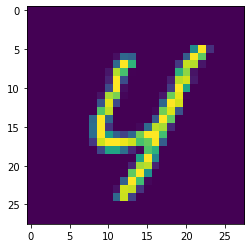

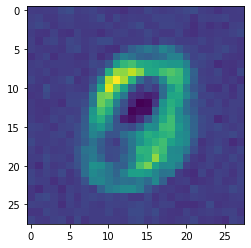

epoch: 1, step: 0, loss: 0.2342318892478943
epoch: 1, step: 200, loss: 0.22177302837371826
epoch: 1, step: 400, loss: 0.21964755654335022


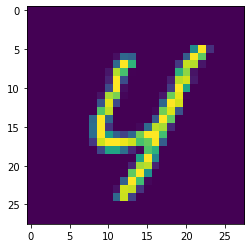

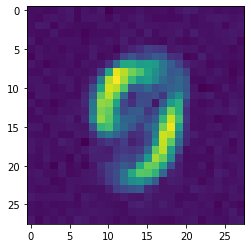

epoch: 2, step: 0, loss: 0.213720440864563
epoch: 2, step: 200, loss: 0.2080860733985901
epoch: 2, step: 400, loss: 0.20276598632335663


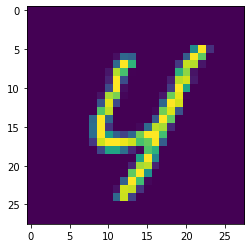

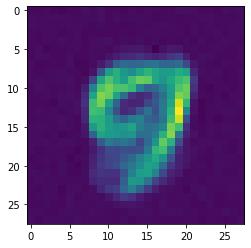

epoch: 3, step: 0, loss: 0.19981485605239868
epoch: 3, step: 200, loss: 0.19414883852005005
epoch: 3, step: 400, loss: 0.18824712932109833


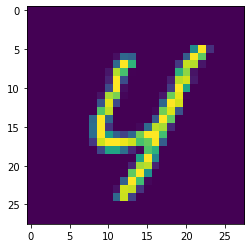

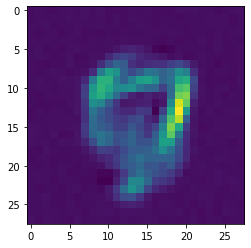

epoch: 4, step: 0, loss: 0.1903146654367447
epoch: 4, step: 200, loss: 0.18552666902542114
epoch: 4, step: 400, loss: 0.18574877083301544


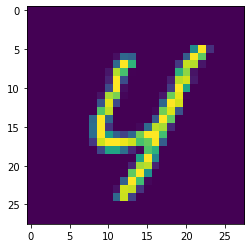

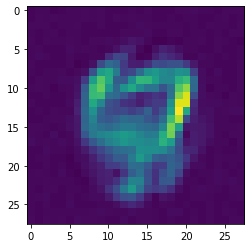

In [13]:
# hidden_out = 40
for epoch in range(n_epochs):
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        optim.zero_grad()
        target = inputs.view(inputs.size(0), -1).to(device)
        predict = model(target)
        loss = loss_func(target, predict)
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    item = dataset_test.data[555].unsqueeze(0).view(1, -1).to(device).float()
    plt.imshow(dataset_test.data[555].detach().numpy())
    plt.show()
    plt.imshow(model(item).view((28, 28)).cpu().detach().numpy())
    plt.show()
    torch.save(model.state_dict(), f'./lin_ae_chkpt_{epoch}.pth')


In [14]:
input_channels = 1
hidden_channels = 64

In [15]:
class ConvEncoder(nn.Module):
  #28x28 -> hidden -> hidden_out
  def __init__(self, input_ch, hidden_ch):
    super().__init__()
    #TODO try to use other layers
    self.conv1 = nn.Conv2d(input_ch, hidden_ch, kernel_size=5, stride=1, 
                           padding=2) # 28 x 28
    self.do1 = nn.Dropout(0.1)
    self.pool1 = nn.MaxPool2d((2, 2)) # 14 x 14

    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1)
    self.do2 = nn.Dropout(0.1)
    self.pool2 = nn.MaxPool2d((2, 2)) # 7 x 7
    
    self.conv3 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=2, 
                         padding=1) # 4 x 4
    self.do3 = nn.Dropout(0.1)
    # self.pool3 = nn.MaxPool2d((2, 1))
    
    self.conv4 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                         padding=1)
    self.do4 = nn.Dropout(0.1)
    self.pool4 = nn.MaxPool2d((2, 2)) # 2 x 2
    
    
    self.conv5 = nn.Conv2d(hidden_ch, 1, kernel_size=3, stride=1, 
                           padding=1)

    self.activ = nn.ReLU()

  def forward(self, x):
    x = self.pool1(self.do1(self.activ(self.conv1(x))))
    x = self.pool2(self.do2(self.activ(self.conv2(x))))
    x = self.do3(self.activ(self.conv3(x)))
    x = self.pool4(self.do4(self.activ(self.conv4(x))))

    return self.conv5(x)

class ConvDecoder(nn.Module):
  #hidden_out-> hidden -> 28*28 
  def __init__(self, input_ch, hidden_ch, ):
    super().__init__()
    #TODO try to use other layers
    self.conv1 = nn.Conv2d(1, hidden_ch, kernel_size=3, stride=1, 
                           padding=1) # 2 x 2
    self.do1 = nn.Dropout(0.1)
    self.upsample1 = nn.UpsamplingNearest2d(scale_factor=2) # 4 x 4

    self.conv2 = nn.ConvTranspose2d(hidden_ch, hidden_ch, kernel_size=3, stride=2, 
                           padding=1) #7 x 7
    self.do2 = nn.Dropout(0.1)
    self.upsample2 = nn.UpsamplingNearest2d(scale_factor=2) # 14 x 14
    
    self.conv3 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1)
    self.do3 = nn.Dropout(0.1)
    
    self.conv4 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1)
    self.do4 = nn.Dropout(0.1)
    self.upsample4 = nn.UpsamplingNearest2d(scale_factor=2) # 28 x 28

    self.conv5 = nn.Conv2d(hidden_ch, input_ch, kernel_size=5, stride=1, 
                           padding=2)
    
    
    self.activ = nn.ReLU()

  def forward(self, x):
    x = self.upsample1(self.do1(self.activ(self.conv1(x))))
    x = self.upsample2(self.do2(self.activ(self.conv2(x))))
    x = self.do2(self.activ(self.conv3(x)))
    x = self.upsample4(self.do2(self.activ(self.conv4(x))))

    return self.conv5(x)

class ConvAutoEncoder(nn.Module):
  def __init__(self, input_ch, hidden_ch, ):
    super().__init__()
    self.encoder = ConvEncoder(input_ch, hidden_ch, )
    self.decoder = ConvDecoder(input_ch, hidden_ch, )

  def forward(self, x):
    hidden = self.encoder(x)
    x_ = self.decoder(hidden)

    return x_


In [17]:
model = ConvAutoEncoder(input_channels, hidden_channels).to(device)
optim = torch.optim.Adam(model.parameters())
loss_func = nn.MSELoss()

epoch: 0, step: 0, loss: 0.9069743752479553
epoch: 0, step: 200, loss: 0.21648575365543365
epoch: 0, step: 400, loss: 0.1627606898546219


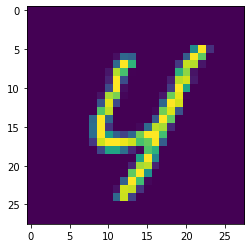

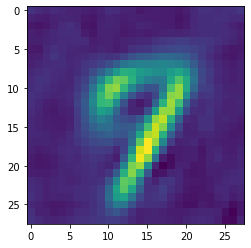

epoch: 1, step: 0, loss: 0.15208271145820618
epoch: 1, step: 200, loss: 0.14486216008663177
epoch: 1, step: 400, loss: 0.14617659151554108


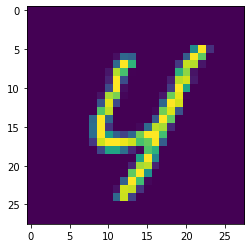

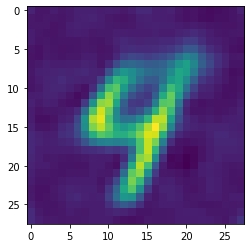

epoch: 2, step: 0, loss: 0.1479487121105194
epoch: 2, step: 200, loss: 0.1357843279838562
epoch: 2, step: 400, loss: 0.14350849390029907


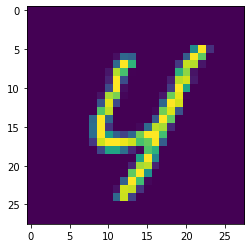

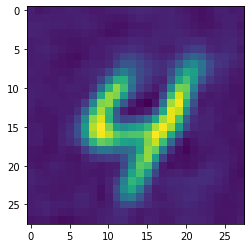

epoch: 3, step: 0, loss: 0.1408788561820984
epoch: 3, step: 200, loss: 0.1307491958141327
epoch: 3, step: 400, loss: 0.1299588531255722


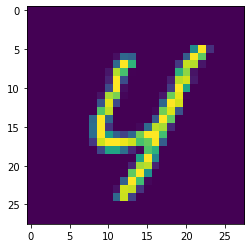

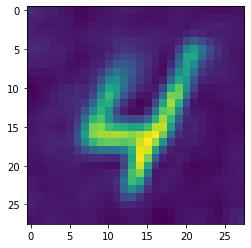

epoch: 4, step: 0, loss: 0.1388659030199051
epoch: 4, step: 200, loss: 0.12678870558738708
epoch: 4, step: 400, loss: 0.13013845682144165


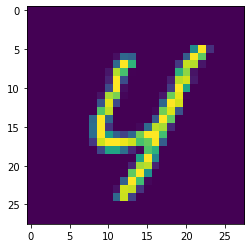

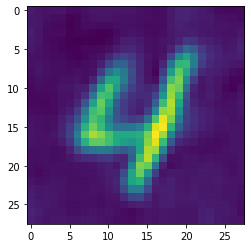

In [18]:
for epoch in range(n_epochs):
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        optim.zero_grad()

        predict = model(inputs.to(device))
        loss = loss_func(inputs.to(device), predict)
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    item = dataset_test[555][0].unsqueeze(0).to(device).float()
    plt.imshow(dataset_test[555][0].squeeze().detach().numpy())
    plt.show()
    plt.imshow(model(item).squeeze().squeeze().cpu().detach().numpy())
    plt.show()
    torch.save(model.state_dict(), f'./lin_ae_chkpt_{epoch}.pth')

In [22]:
class ConvEncoder1(nn.Module):
  #28x28 -> hidden -> hidden_out
  def __init__(self, input_ch, hidden_ch):
    super().__init__()
    #TODO try to use other layers
    self.conv1 = nn.Conv2d(input_ch, hidden_ch, kernel_size=5, stride=1, 
                           padding=2) # 28 x 28
    self.do1 = nn.Dropout(0.1)
    self.pool1 = nn.MaxPool2d((2, 2)) # 14 x 14

    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1)
    self.do2 = nn.Dropout(0.1)
    self.pool2 = nn.MaxPool2d((2, 2)) # 7 x 7
    
    
    self.conv3 = nn.Conv2d(hidden_ch, 1, kernel_size=3, stride=1, 
                           padding=1)

    self.activ = nn.ReLU()

  def forward(self, x):
    x = self.pool1(self.do1(self.activ(self.conv1(x))))
    x = self.pool2(self.do2(self.activ(self.conv2(x))))
    x = self.activ(self.conv3(x))
    x = x.view(x.size(0), -1)

    return x

class ConvDecoder1(nn.Module):
  #hidden_out-> hidden -> 28*28 
  def __init__(self, input_ch, hidden_ch, ):
    super().__init__()
    #TODO try to use other layers
    self.conv1 = nn.Conv2d(1, hidden_ch, kernel_size=3, stride=1, 
                           padding=1) # 7 x 7
    self.do1 = nn.Dropout(0.1)
    self.upsample1 = nn.UpsamplingNearest2d(scale_factor=2) # 14 x 14
    
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1)
    self.do2 = nn.Dropout(0.1)
    self.upsample2 = nn.UpsamplingNearest2d(scale_factor=2) # 28 x 28

    self.conv3 = nn.Conv2d(hidden_ch, input_ch, kernel_size=5, stride=1, 
                           padding=2)
    
    self.activ = nn.ReLU()

  def forward(self, x):
    x = self.upsample1(self.do1(self.activ(self.conv1(x))))
    x = self.upsample2(self.do2(self.activ(self.conv2(x))))

    return self.conv3(x)


class Linear(nn.Module):
  #2*2 -> hidden -> hidden_out
  def __init__(self, ):
    super().__init__()
    #TODO try to use other layers
    self.linear1 = nn.Linear(1*7*7, 150)
    self.activ = nn.ReLU()
    self.linear2 = nn.Linear(150, 1*7*7)
    self.unflatten = nn.Unflatten(dim=1, unflattened_size=(1, 7, 7))
    
  def forward(self, x):
    x = self.activ(self.linear1(x))
    x = self.activ(self.linear2(x))

    return self.unflatten(x)

class ConvAutoEncoder1(nn.Module):
  def __init__(self, input_ch, hidden_ch, ):
    super().__init__()
    self.encoder = ConvEncoder1(input_ch, hidden_ch, )
    self.linear = Linear()
    self.decoder = ConvDecoder1(input_ch, hidden_ch, )

  def forward(self, x):
    hidden = self.encoder(x)
    linear = self.linear(hidden)
    x_ = self.decoder(linear)

    return x_

In [25]:
model1 = ConvAutoEncoder1(input_channels, hidden_channels).to(device)
optim = torch.optim.Adam(model1.parameters())
loss_func = nn.MSELoss() #TODO try to use MAE
# loss_func = nn.L1Loss() плохо работает

epoch: 0, step: 0, loss: 0.92057204246521
epoch: 0, step: 200, loss: 0.18657328188419342
epoch: 0, step: 400, loss: 0.13342618942260742


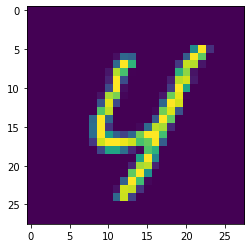

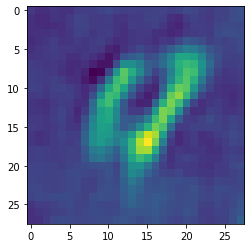

epoch: 1, step: 0, loss: 0.12779057025909424
epoch: 1, step: 200, loss: 0.1127539724111557
epoch: 1, step: 400, loss: 0.09734420478343964


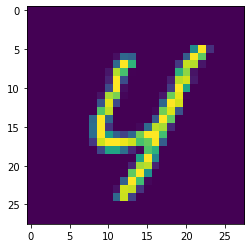

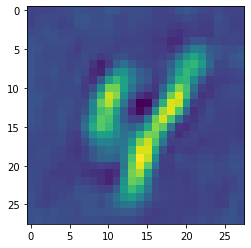

epoch: 2, step: 0, loss: 0.09870215505361557
epoch: 2, step: 200, loss: 0.09005031734704971
epoch: 2, step: 400, loss: 0.08464451879262924


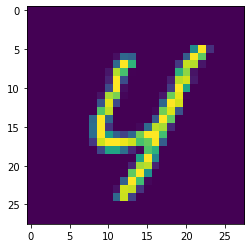

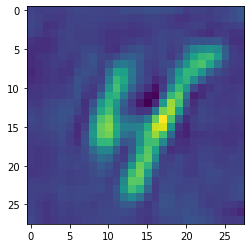

epoch: 3, step: 0, loss: 0.08732116967439651
epoch: 3, step: 200, loss: 0.0852966383099556
epoch: 3, step: 400, loss: 0.08043360710144043


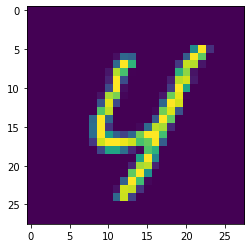

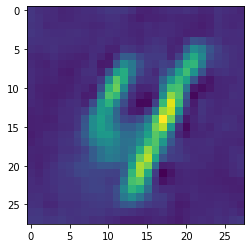

epoch: 4, step: 0, loss: 0.08111201971769333
epoch: 4, step: 200, loss: 0.07446274161338806
epoch: 4, step: 400, loss: 0.07637237012386322


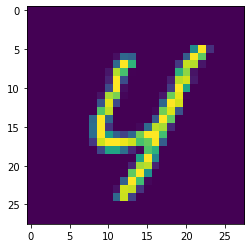

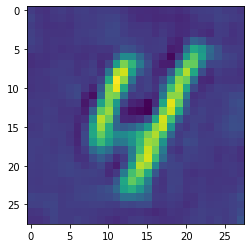

In [26]:
for epoch in range(n_epochs):
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        optim.zero_grad()

        predict = model1(inputs.to(device))
        loss = loss_func(inputs.to(device), predict)
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    item = dataset_test[555][0].unsqueeze(0).to(device).float()
    plt.imshow(dataset_test[555][0].squeeze().detach().numpy())
    plt.show()
    plt.imshow(model1(item).squeeze().squeeze().cpu().detach().numpy())
    plt.show()
    torch.save(model1.state_dict(), f'./lin_ae_chkpt_{epoch}.pth')

epoch: 0, step: 0, loss: 0.947871744632721
epoch: 0, step: 200, loss: 0.2875562012195587
epoch: 0, step: 400, loss: 0.24428407847881317


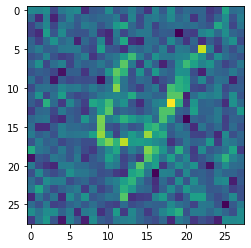

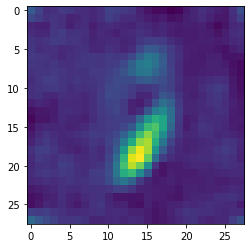

epoch: 1, step: 0, loss: 0.24485409259796143
epoch: 1, step: 200, loss: 0.193107470870018
epoch: 1, step: 400, loss: 0.18914495408535004


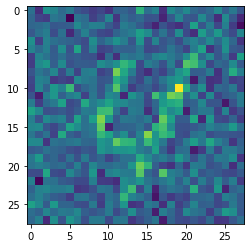

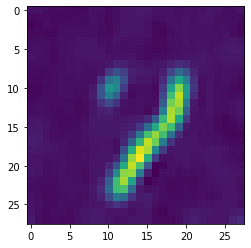

epoch: 2, step: 0, loss: 0.18216745555400848
epoch: 2, step: 200, loss: 0.18062929809093475
epoch: 2, step: 400, loss: 0.1801799237728119


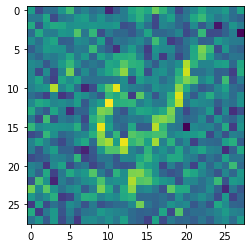

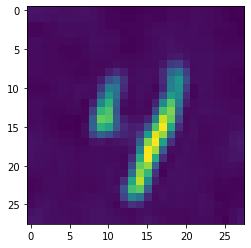

epoch: 3, step: 0, loss: 0.17651374638080597
epoch: 3, step: 200, loss: 0.16872958838939667
epoch: 3, step: 400, loss: 0.16430336236953735


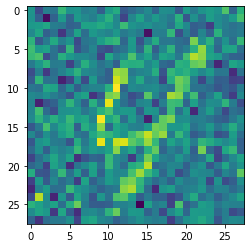

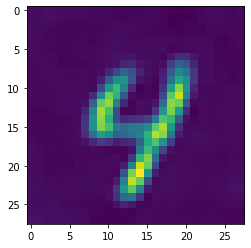

epoch: 4, step: 0, loss: 0.1599123626947403
epoch: 4, step: 200, loss: 0.16838622093200684
epoch: 4, step: 400, loss: 0.1563587486743927


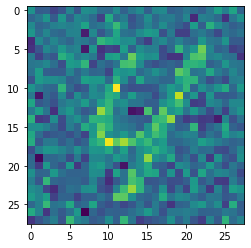

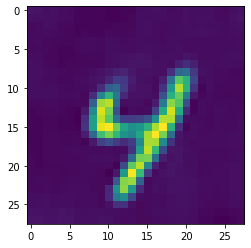

In [27]:
model = ConvAutoEncoder(input_channels, hidden_channels).to(device)
optim = torch.optim.Adam(model.parameters())
# loss_func = nn.MSELoss() #TODO try to use MAE
loss_func = nn.L1Loss()

for epoch in range(n_epochs):
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        optim.zero_grad()
        inputs = inputs.to(device)
        noise_inputs = inputs + \
        torch.normal(torch.zeros_like(inputs), torch.ones_like(inputs)) * 0.7 
        predict = model(noise_inputs)
        loss = loss_func(inputs, predict)
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    item = dataset_test[555][0].unsqueeze(0).to(device).float()
    item = item + torch.normal(torch.zeros_like(item), torch.ones_like(item)) * 0.7
    plt.imshow(item.squeeze().squeeze().cpu().detach().numpy())
    plt.show()
    plt.imshow(model(item).squeeze().squeeze().cpu().detach().numpy())
    plt.show()
    torch.save(model.state_dict(), f'./lin_ae_chkpt_{epoch}.pth')

In [29]:
class ConvVAEncoder(nn.Module):
  #28*28 -> hidden -> hidden_out
  def __init__(self, input_ch, hidden_ch):
    super().__init__()
    #TODO try to use other layers
    self.conv1 = nn.Conv2d(input_ch, hidden_ch, kernel_size=5, stride=1, 
                           padding=2) # 28x28
    self.do1 = nn.Dropout(0.1)
    self.pool1 = nn.MaxPool2d(2, 2) # 14x14
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1) # 14x14
    self.do2 = nn.Dropout(0.1)
    self.pool2 = nn.MaxPool2d(2, 2) # 7x7

    self.conv3 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=2, 
                         padding=1) # 4 x 4
    self.do3 = nn.Dropout(0.1)
    
    self.conv4 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                         padding=1)
    self.do4 = nn.Dropout(0.1)
    self.pool4 = nn.MaxPool2d((2, 2)) # 2 x 2

    self.conv5_mu = nn.Conv2d(hidden_ch, 1, kernel_size=3, stride=1, 
                           padding=1) # 2x2
    self.conv5_sigma = nn.Conv2d(hidden_ch, 1, kernel_size=3, stride=1, 
                           padding=1) # 2x2
    self.activ = nn.ReLU()

  def forward(self, x):
    x = self.pool1(self.do1(self.activ(self.conv1(x))))
    x = self.pool2(self.do2(self.activ(self.conv2(x))))
    x = self.do3(self.activ(self.conv3(x)))
    x = self.pool4(self.do4(self.activ(self.conv4(x))))

    mu = self.conv5_mu(x)
    sigma = torch.exp(self.conv5_sigma(x))

    return mu, sigma

class ConvDecoder(nn.Module):
  #hidden_out-> hidden -> 28*28 
  def __init__(self, input_ch, hidden_ch, ):
    super().__init__()
    #TODO try to use other layers
    self.conv1 = nn.Conv2d(1, hidden_ch, kernel_size=3, stride=1, 
                           padding=1) # 2 x 2
    self.do1 = nn.Dropout(0.1)
    self.upsample1 = nn.UpsamplingNearest2d(scale_factor=2) # 4 x 4

    self.conv2 = nn.ConvTranspose2d(hidden_ch, hidden_ch, kernel_size=3, stride=2, 
                           padding=1) #7 x 7
    self.do2 = nn.Dropout(0.1)
    self.upsample2 = nn.UpsamplingNearest2d(scale_factor=2) # 14 x 14
    
    self.conv3 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1)
    self.do3 = nn.Dropout(0.1)
    
    self.conv4 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1)
    self.do4 = nn.Dropout(0.1)
    self.upsample4 = nn.UpsamplingNearest2d(scale_factor=2) # 28 x 28

    self.conv5 = nn.Conv2d(hidden_ch, input_ch, kernel_size=5, stride=1, 
                           padding=2)
    
    
    self.activ = nn.ReLU()

  def forward(self, x):
    x = self.upsample1(self.do1(self.activ(self.conv1(x))))
    x = self.upsample2(self.do2(self.activ(self.conv2(x))))
    x = self.do2(self.activ(self.conv3(x)))
    x = self.upsample4(self.do2(self.activ(self.conv4(x))))

    return self.conv5(x)

def sampling(mu, sigma):
    return torch.normal(torch.zeros_like(mu), torch.ones_like(mu)) * sigma + mu

class ConvVAE(nn.Module):
  def __init__(self, input_ch, hidden_ch, ):
    super().__init__()
    self.encoder = ConvVAEncoder(input_ch, hidden_ch, )
    self.decoder = ConvDecoder(input_ch, hidden_ch, )

  def forward(self, x):
    mu, sigma = self.encoder(x)
    hidden = sampling(mu, sigma)
    x_ = self.decoder(hidden)

    return x_, mu, sigma

epoch: 0, step: 0, loss: 0.9608163237571716
epoch: 0, step: 200, loss: 0.25478118658065796
epoch: 0, step: 400, loss: 0.1983320564031601


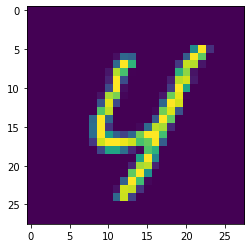

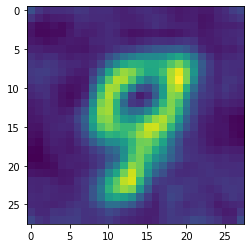

epoch: 1, step: 0, loss: 0.2025231122970581
epoch: 1, step: 200, loss: 0.18339458107948303
epoch: 1, step: 400, loss: 0.17560221254825592


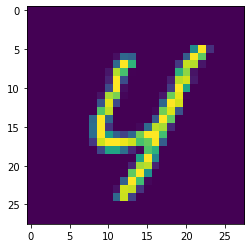

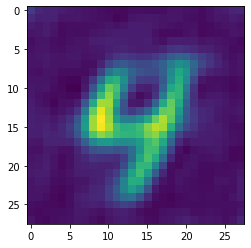

epoch: 2, step: 0, loss: 0.1719142496585846
epoch: 2, step: 200, loss: 0.1629619002342224
epoch: 2, step: 400, loss: 0.17650870978832245


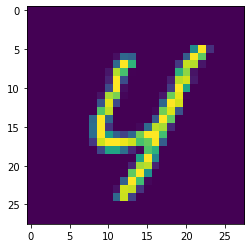

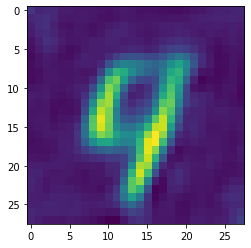

epoch: 3, step: 0, loss: 0.15718945860862732
epoch: 3, step: 200, loss: 0.16451364755630493
epoch: 3, step: 400, loss: 0.1569569706916809


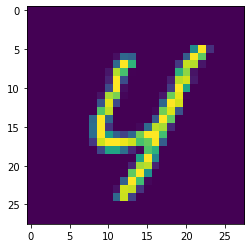

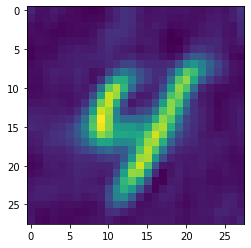

epoch: 4, step: 0, loss: 0.15830892324447632
epoch: 4, step: 200, loss: 0.1618213951587677
epoch: 4, step: 400, loss: 0.15449082851409912


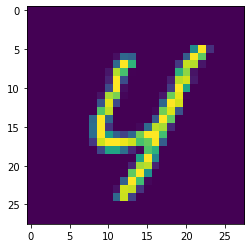

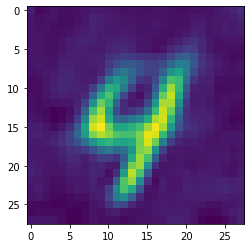

In [30]:
def kl_loss(mu, sigma):
    p = torch.distributions.Normal(mu, sigma)
    q = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(mu))
    return torch.distributions.kl_divergence(p, q).mean()

model = ConvVAE(input_channels, hidden_channels).to(device)
optim = torch.optim.Adam(model.parameters())
loss_func = nn.MSELoss() #TODO try to use MAE

for epoch in range(n_epochs):
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        optim.zero_grad()
        inputs = inputs.to(device)
        # noise_inputs = inputs + \
        # torch.normal(torch.zeros_like(inputs), torch.ones_like(inputs)) * 0.7 
        predict, mu, sigma = model(inputs)
        loss = loss_func(inputs, predict) + 0.01 * kl_loss(mu, sigma)
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    item = dataset_test[555][0].unsqueeze(0).to(device).float()
    # item = item + torch.normal(torch.zeros_like(item), torch.ones_like(item)) * 0.7
    plt.imshow(item.squeeze().squeeze().cpu().detach().numpy())
    plt.show()
    plt.imshow(model(item)[0].squeeze().squeeze().cpu().detach().numpy())
    plt.show()
    torch.save(model.state_dict(), f'./lin_ae_chkpt_{epoch}.pth')

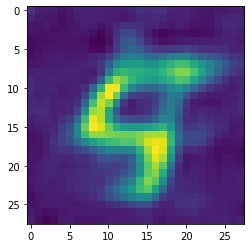

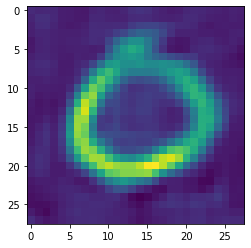

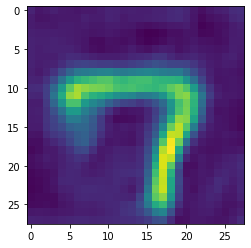

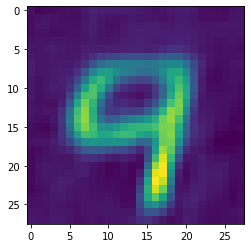

In [31]:
item = dataset_test[555][0].unsqueeze(0).to(device).float()

for _ in range(4):
    hid = torch.normal(torch.zeros((1,1,2,2)), torch.ones((1,1,2,2))).to(device) 
    plt.imshow(model.decoder(hid).squeeze().squeeze().cpu().detach().numpy())
    plt.show()